In [32]:
import os
import numpy as np
import torch
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch 
import time
from audioldm import build_model
from audioldm.latent_diffusion.ddim import DDIMSampler
from audioldm.pipeline import duration_to_latent_t_size
from utils.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.cuda.set_device(0)  
sr = 16000

#test
#Saturn is working
#Saturn is working
#Saturn is working

In [33]:
model = build_model(model_name="audioldm-m-full")

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()

modelmem = torch.cuda.memory_allocated() / (1024 * 1024) 

print(f"{modelmem} MiB")
print(torch.cuda.memory_summary())

Load AudioLDM: %s audioldm-m-full
DiffusionWrapper has 415.95 M params.
DiffusionWrapper has 415.95 M params.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8880.0771484375 MiB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8880 MiB |   8880 MiB |  28218 GiB |  28209 GiB |
|       from large pool |   8621 MiB |   8621 MiB |  28136 GiB |  28128 GiB |
|       from small pool |    258 MiB |    258 MiB |     81 GiB |     80 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   8880 MiB |   8880 MiB |  28218 GiB |  28209 GiB |
|       from large pool |   8621 MiB |   862

In [34]:
prompt = "90s rock song with electric guitar and heavy drums"
duration = 30.0  

In [35]:
model.cond_stage_model.embed_mode = "text"
text_list = [prompt] 

text_emb = model.get_learned_conditioning(text_list)

unconditional_text = ["low quality and unclear"] 
# low quality, noisy, distorted, robotic, clipping, unnatural, bad mixing, echo, flat, static
unconditional_embedding = model.get_learned_conditioning(unconditional_text)

In [36]:
sampler = DDIMSampler(model)

torch.cuda.synchronize()
latent_size = duration_to_latent_t_size(duration)
shape = [model.channels, latent_size, model.latent_f_size]
z = torch.randn([1] + shape).to(model.device)

ddim_steps = 200
ddim_eta = 0.1
unconditional_guidance_scale = 3.0

memory_before_diffusion = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run diffusion
start_time = time.time()
with torch.no_grad(): 
    samples, _ = sampler.sample(
        S=ddim_steps,  
        batch_size=1,
        shape=shape,
        conditioning=text_emb,
        unconditional_conditioning=unconditional_embedding,
        unconditional_guidance_scale=unconditional_guidance_scale,
        eta=ddim_eta,
        verbose=False,
        x_T=z
    )
torch.cuda.synchronize()

# Get time and memory
diffusion_time = time.time() - start_time
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_diffusion

print(f"DIFFUSION ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"DIFFUSION CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"DIFFUSION TIME: {diffusion_time:.1f}s ({diffusion_time/ddim_steps:.3f}s per step)")

DDIM Sampler:   0%|          | 0/200 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 200/200 [00:58<00:00,  3.44it/s]

DIFFUSION ISOLATED PEAK: 6328.9 MiB (cost: +1885.1 MiB)
DIFFUSION CURRENT MEMORY: 4443.5 MiB
DIFFUSION TIME: 58.2s (0.291s per step)


VAE DECODER ISOLATED PEAK: 5716.3 MiB (cost: +1272.8 MiB)
VAE DECODER CURRENT MEMORY: 4443.5 MiB
VAE TIME: 0.1s


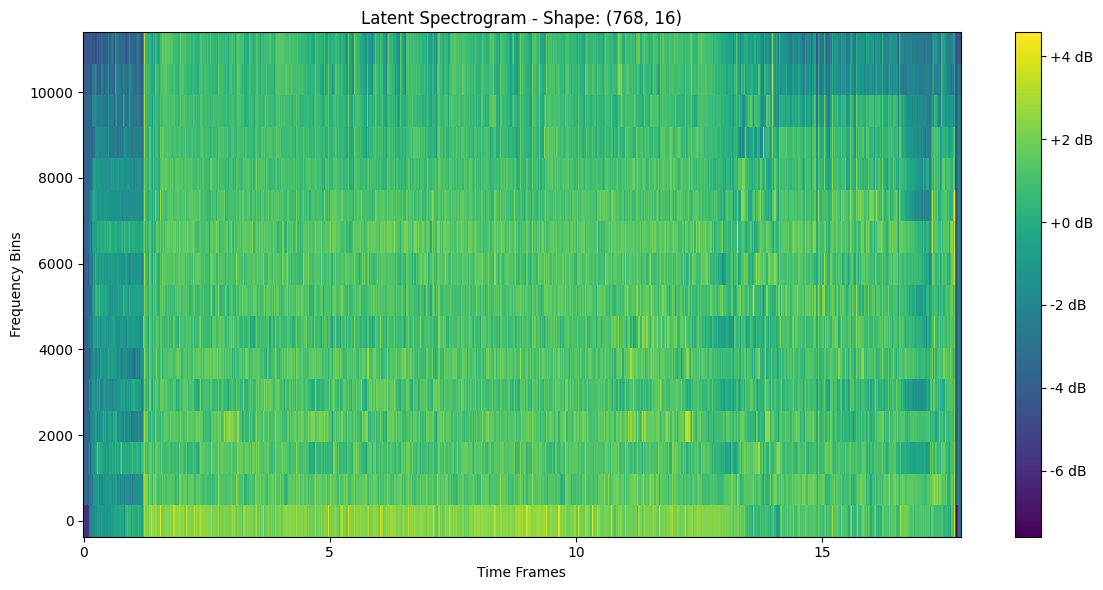

Latent stats - Min: -7.594, Max: 4.580, Mean: 0.717, Std: 1.208


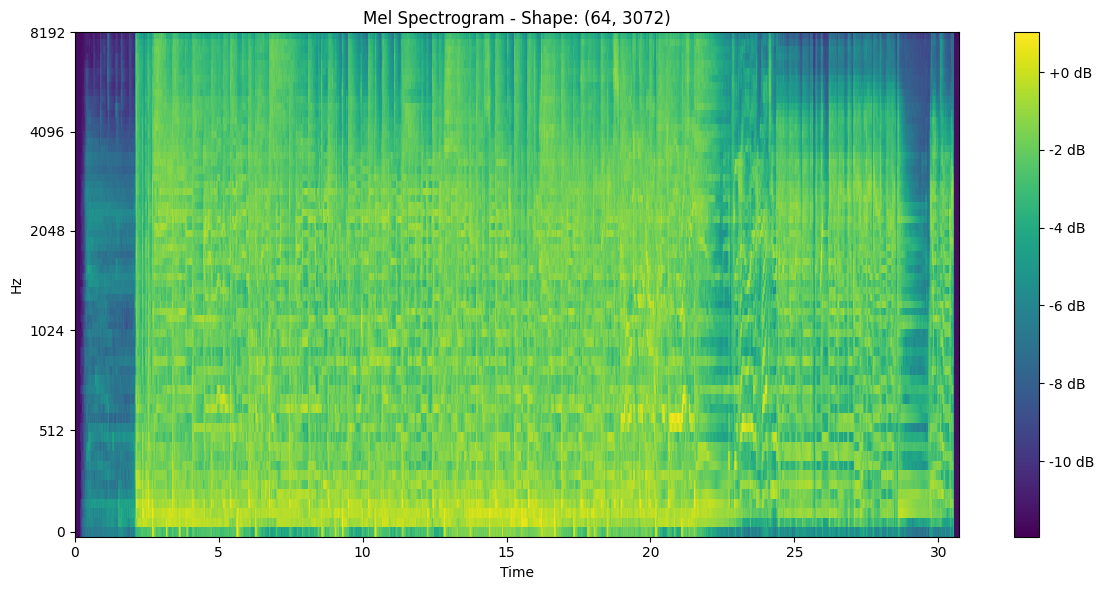

Mel stats - Min: -11.947, Max: 1.022, Mean: -2.888, Std: 2.083


In [37]:
# VAE DECODER VRAM MEASUREMENT
# Get memory before VAE and reset peak tracker
memory_before_vae = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

# Run VAE
start_time = time.time()
with torch.no_grad(): 
    mel_spectrogram = model.decode_first_stage(samples)
torch.cuda.synchronize()
vae_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vae

print(f"VAE DECODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VAE DECODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VAE TIME: {vae_time:.1f}s")
# print(torch.cuda.memory_summary())

plot_latent_spectrogram(samples, title="Latent Spectrogram")
plot_mel_spectrogram(mel_spectrogram, title="Mel Spectrogram", sr=sr)

In [38]:
memory_before_vocoder = torch.cuda.memory_allocated() / (1024 * 1024)
torch.cuda.reset_peak_memory_stats()

start_time = time.time()
with torch.no_grad(): 
    waveform = model.mel_spectrogram_to_waveform(mel_spectrogram)[0]
torch.cuda.synchronize()
vocoder_time = time.time() - start_time

# Get memory usage
isolated_peak = torch.cuda.max_memory_allocated() / (1024 * 1024)  # Convert to MiB
current_memory = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MiB
isolated_cost = isolated_peak - memory_before_vocoder

print(f"VOCODER ISOLATED PEAK: {isolated_peak:.1f} MiB (cost: +{isolated_cost:.1f} MiB)")
print(f"VOCODER CURRENT MEMORY: {current_memory:.1f} MiB")
print(f"VOCODER TIME: {vocoder_time:.1f}s")

ipd.display(ipd.Audio(waveform, rate=sr))

VOCODER ISOLATED PEAK: 4806.3 MiB (cost: +362.8 MiB)
VOCODER CURRENT MEMORY: 4443.5 MiB
VOCODER TIME: 0.2s


In [39]:
# import soundfile as sf

# # Ensure waveform is a NumPy array and has the correct shape
# waveform = waveform.squeeze()  # Remove batch dimension if present
# if isinstance(waveform, torch.Tensor):
#     waveform = waveform.cpu().numpy()  # Convert to NumPy array if it's a PyTorch tensor

# # Save the generated audio to a file
# output_path = "../output/generation"
# os.makedirs(output_path, exist_ok=True)
# filename = f"complex_regular.wav"  # Simplify filename
# sf.write(os.path.join(output_path, filename), waveform, sr)

# print(f"Audio saved to {os.path.join(output_path, filename)}")